In [1]:
import pandas as pd
pd.set_option('display.max_colwidth', None)

In [2]:
import numpy as np
np.bool = np.bool_

In [3]:
#current notebook name
notebook_name = __session__.replace('.ipynb','')[__session__.rfind('/')+1:] 

In [4]:
# HDFS base paths
hdfs_lakehouse_base_path = 'hdfs://localhost:9000/lakehouse/'
hdfs_warehouse_base_path = 'hdfs://localhost:9000/warehouse'

In [5]:
import os
dependencies = ["org.apache.spark:spark-avro_2.12:3.5.0",
                "io.delta:delta-iceberg_2.12:3.0.0"]
os.environ['PYSPARK_SUBMIT_ARGS']= f"--packages {','.join(dependencies)} pyspark-shell"
os.environ['PYARROW_IGNORE_TIMEZONE'] = 'true'

In [6]:
from pyspark.sql.session import SparkSession

spark = (SparkSession.builder
    .appName(notebook_name)
    .config("spark.log.level","ERROR")
    .config("spark.sql.warehouse.dir",hdfs_warehouse_base_path)
    .config("spark.sql.extensions", "io.delta.sql.DeltaSparkSessionExtension")
    .config("spark.sql.catalog.spark_catalog", "org.apache.spark.sql.delta.catalog.DeltaCatalog")
    .config("spark.executorEnv.PYTHONPATH", "/path/to/your/venv/lib/python3.11/site-packages") \

    .enableHiveSupport()
    .getOrCreate()
)

25/03/17 20:10:59 WARN Utils: Your hostname, osbdet resolves to a loopback address: 127.0.0.1; using 10.0.2.15 instead (on interface enp0s1)
25/03/17 20:10:59 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Ivy Default Cache set to: /home/osbdet/.ivy2/cache
The jars for the packages stored in: /home/osbdet/.ivy2/jars
org.apache.spark#spark-avro_2.12 added as a dependency
io.delta#delta-iceberg_2.12 added as a dependency
:: resolving dependencies :: org.apache.spark#spark-submit-parent-8e873a00-0df0-482d-8898-1065025cfc0c;1.0
	confs: [default]


:: loading settings :: url = jar:file:/home/osbdet/.jupyter_venv/lib/python3.11/site-packages/pyspark/jars/ivy-2.5.1.jar!/org/apache/ivy/core/settings/ivysettings.xml


	found org.apache.spark#spark-avro_2.12;3.5.0 in central
	found org.tukaani#xz;1.9 in central
	found io.delta#delta-iceberg_2.12;3.0.0 in central
	found io.delta#delta-spark_2.12;3.0.0 in central
	found io.delta#delta-storage;3.0.0 in central
	found org.antlr#antlr4-runtime;4.9.3 in central
	found org.scala-lang.modules#scala-collection-compat_2.12;2.1.1 in central
	found com.github.ben-manes.caffeine#caffeine;2.9.3 in central
	found org.checkerframework#checker-qual;3.19.0 in central
	found com.google.errorprone#error_prone_annotations;2.10.0 in central
:: resolution report :: resolve 180ms :: artifacts dl 8ms
	:: modules in use:
	com.github.ben-manes.caffeine#caffeine;2.9.3 from central in [default]
	com.google.errorprone#error_prone_annotations;2.10.0 from central in [default]
	io.delta#delta-iceberg_2.12;3.0.0 from central in [default]
	io.delta#delta-spark_2.12;3.0.0 from central in [default]
	io.delta#delta-storage;3.0.0 from central in [default]
	org.antlr#antlr4-runtime;4.9.3 f

In [7]:
sentiment_btc_change_df = spark.read.format("delta").load(f"{hdfs_lakehouse_base_path}/gold/trump_btc/sentiment_analysis_with_btc_change").cache()
fg_df = spark.read.format("delta").load(f"{hdfs_lakehouse_base_path}/silver/trump_btc/fear_greed_index").cache()



In [8]:
fg_df.toPandas()

,Date,Value,Value_Classification,BTC_Volume
0,2018-02-01,30.0,Fear,9959400448
1,2018-02-02,15.0,Extreme Fear,12726899712
2,2018-02-03,40.0,Fear,7263790080
3,2018-02-04,24.0,Extreme Fear,7073549824
4,2018-02-05,11.0,Extreme Fear,9285289984
...,...,...,...,...
1877,2023-03-27,64.0,Greed,18188895178
1878,2023-03-28,59.0,Greed,17783600385
1879,2023-03-29,57.0,Greed,20684945906
1880,2023-03-30,60.0,Greed,22435349951


In [9]:
sentiment_btc_change_df.toPandas()

,text,date,sentiment_score,btc_current_price,btc_price_1d_later,btc_price_2d_later,btc_price_3d_later,btc_price_5d_later,btc_price_7d_later,price_change_1d_in_%,price_change_2d_in_%,price_change_3d_in_%,price_change_5d_in_%,price_change_7d_in_%
0,Gallup poll proves that @BarackObama's regulation and Obamacare are stopping small business owners from hiring http://t.co/Yhs8s8UJ SHOCK!,2012-02-16 21:45:00,-0.6399,4.59,4.66,4.21,4.33,4.54,5.00,1.53,-8.28,-5.66,-1.09,8.93
1,@BarackObama's Energy Sec. called for $7-$9 gas in January. Wish granted. http://t.co/6Ftd60Np @BarackObama owns the gas prices.,2012-02-28 20:54:00,0.7003,5.06,4.91,5.04,4.64,4.80,5.05,-2.96,-0.40,-8.30,-5.14,-0.20
2,"""The real unemployment rate according to the CBO is 15% http://t.co/aZveAoW0 @BarackObama's economic recovery is all """"Hope""""""",2012-03-01 21:02:00,0.0000,5.04,4.64,4.65,4.80,5.05,4.96,-7.94,-7.74,-4.76,0.20,-1.59
3,White House Press Sec. had a hard time explaining why @BarackObama supported tax breaks for oil companies in (cont) http://t.co/GvLfD5AY,2012-03-30 20:24:00,0.2263,4.91,4.89,4.80,4.82,5.01,4.94,-0.41,-2.24,-1.83,2.04,0.61
4,"By @BarackObama's design, the middle class will be hit with record taxes under ObamaCare through inflation \nhttp://t.co/cZc9SRS6 REPEAL!",2012-04-18 20:52:00,0.0000,5.14,5.13,5.12,5.20,5.16,5.11,-0.19,-0.39,1.17,0.39,-0.58
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
782,"I am NOT proposing a National Sales Tax, as the Democrats say in their Advertisements against me. Dems know what they are saying is a blatant lie. I am proposing tariffs on other countries that take advantage of us, hardly a NST. These tariffs are paid for by the abusing country, NOT THE AMERICAN CONSUMER. They do not cause inflation, and will MAKE AMERICA RICH AGAIN!",2024-10-24 21:43:00,0.5610,68163.00,NaN,66999.00,NaN,NaN,NaN,NaN,-1.71,NaN,NaN,NaN
783,"""RT @TeamTrumpPRESIDENT TRUMP: """"I am here today with a message of hope for all Americans: With your vote in this election",2024-10-26 20:53:00,0.4404,67004.00,NaN,69579.00,NaN,NaN,NaN,NaN,3.84,NaN,NaN,NaN
784,"Orlando Sonza is a terrific America First Candidate running to represent the Great People of Ohio’s 1st Congressional District! A West Point Graduate, U.S. Army Veteran, and Former Criminal Prosecutor, Orlando knows how to Strengthen our Military, Care for our Veterans, Stop Crime, Stand with our Brave Law Enforcement, Secure our Border, and Defend our always under siege Second Amendment. As a very successful Small Businessman, Orlando will fight hard to Stop Inflation, Grow the Economy, Lower Taxes, Unleash American Energy, and Eliminate Government Waste. Orlando Sonza has my Complete and Total Endorsement - HE WILL NEVER LET YOU DOWN!",2024-10-30 15:30:00,0.8615,72087.00,NaN,71514.00,NaN,NaN,NaN,NaN,-0.79,NaN,NaN,NaN
785,"""RT @TeamTrumpPRESIDENT TRUMP: IN CONCLUSION",2024-11-03 19:15:00,0.0000,68333.00,NaN,69737.00,NaN,NaN,NaN,NaN,2.05,NaN,NaN,NaN


In [10]:
from pyspark.sql.functions import to_date

sentiment_btc_change_df = sentiment_btc_change_df.withColumn("date_only", to_date("date"))
fg_df = fg_df.withColumn("Date_only", to_date("Date"))
fg_df=fg_df.drop("Date") #dropping the "Date" column since we only want the date column from the sentiment with the time

# Perform an inner join on the date-only columns
merged_df = sentiment_btc_change_df.join(fg_df, sentiment_btc_change_df["date_only"] == fg_df["Date_only"], "inner")

# Drop the duplicate date-only column from FG_df after merging
merged_df = merged_df.drop("Date_only")

# Show result (date with timestamp is still present)
merged_df.toPandas()


,text,date,sentiment_score,btc_current_price,btc_price_1d_later,btc_price_2d_later,btc_price_3d_later,btc_price_5d_later,btc_price_7d_later,price_change_1d_in_%,price_change_2d_in_%,price_change_3d_in_%,price_change_5d_in_%,price_change_7d_in_%,Value,Value_Classification,BTC_Volume
0,"With 3.5 million Americans receiving bonuses or other benefits from their employers as a result of TAX CUTS, 2018 is off to great start!✅Unemployment rate at 4.1%.✅Average earnings up 2.9% in the last year.✅200,000 new American jobs.✅#MAGA🇺🇸 https://t.co/upqSvBhRqJ",2018-02-02 19:05:00,0.8252,8400.00,8959.99,8705.29,7673.33,8477.62,8229.96,6.67,3.63,-8.65,0.92,-2.02,15.0,Extreme Fear,12726899712
1,“American consumers are the most confident they've been since 2000....A strong job market is boosting confidence. The unemployment rate has stayed at a 17-year low.” https://t.co/aL7aVoR7XC,2018-02-27 19:18:00,0.8622,10699.32,10449.97,10673.23,10987.99,11187.74,10908.84,-2.33,-0.24,2.70,4.56,1.96,44.0,Fear,6966179840
2,"RT @IvankaTrump: Looking forward to traveling to Manchester, NH tomorrow with Sec @stevenmnuchin1 to celebrate the last #TaxDay under the o…",2018-04-17 02:57:00,0.8240,7990.29,7917.69,8185.90,8239.59,8781.58,8917.13,-0.91,2.45,3.12,9.90,11.60,26.0,Fear,6900879872
3,"Stock Market up almost 40% since the Election, with 7 Trillion Dollars of U.S. value built throughout the economy. Lowest unemployment rate in many decades, with Black &amp, Hispanic unemployment lowest in History, and Female unemployment lowest in 21 years. Highest confidence ever!",2018-06-11 23:52:00,-0.8777,6725.61,6744.43,6296.91,6588.83,6514.00,6732.73,0.28,-6.37,-2.03,-3.15,0.11,15.0,Extreme Fear,4745269760
4,RT @Scavino45: “Hispanic-Latino Unemployment Rate Hits Lowest Level on Record in June” https://t.co/27VkUgSVso,2018-07-07 14:06:00,-0.6705,6591.65,6742.98,6727.31,6616.31,6179.69,6217.18,2.30,2.06,0.37,-6.25,-5.68,34.0,Fear,3961080064
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
333,"IT’S TIME!!! WE ARE A NATION IN STEEP DECLINE, BEING LED INTO WORLD WAR III BY A CROOKED POLITICIAN WHO DOESN’T EVEN KNOW HE’S ALIVE, BUT WHO IS SURROUNDED BY EVIL &amp; SINISTER PEOPLE WHO, BASED ON THEIR ACTIONS ON DEFUNDING THE POLICE, DESTROYING OUR MILITARY, OPEN BORDERS, NO VOTER I.D., INFLATION, RAISING TAXES, &amp; MUCH MORE, CAN ONLY HATE OUR NOW FAILING USA. WE JUST CAN’T ALLOW THIS ANYMORE. THEY’RE KILLING OUR NATION AS WE SIT BACK &amp; WATCH. WE MUST SAVE AMERICA!PROTEST, PROTEST, PROTEST!!!",2023-03-18 17:29:00,-0.9946,27511.00,27279.00,28292.00,28036.00,27680.00,27455.00,-0.84,2.84,1.91,0.61,-0.20,64.0,Greed,35723036817
334,"""RT @realDonaldTrumpOUR NATION IS NOW THIRD WORLD &amp; DYING. THE AMERICAN DREAM IS DEAD! THE RADICAL LEFT ANARCHISTS HAVE STOLLEN OUR PRESIDENTIAL ELECTION",2023-03-18 22:46:00,-0.5562,27268.00,28087.00,27864.00,28196.00,28326.00,27561.00,3.00,2.19,3.40,3.88,1.07,64.0,Greed,35723036817
335,"China, Russia, Iran, North Korea and other Nations of a less than friendly nature, are busy “CARVING UP THE WORLD” as our once great United States of America sits back and watches. We are a Failing Nation, with Open Borders, Fake Elections, and a horrible Inflation Riddled Economy. We no longer set the standard, the standard sets us. Our so-called “Leader” does NOTHING except Eat, Sleep, and S..t! Where have you gone Joe DiMaggio?”",2023-03-20 04:00:00,-0.3758,28168.00,28046.00,28098.00,27270.00,27336.00,27867.00,-0.43,-0.25,-3.19,-2.95,-1.07,66.0,Greed,44774027664
336,"""https://justthenews.com/government/security/tuetwo-years-later-jan-6-video-footage-raises-new-questions-about-police-and""",2023-03-29 19:09:00,0.0000,28449.00,28631.00,28189.00,28462.00,28148.00,28569.00,0.64,-0.91,0.05,-1.06,0.42,57.0,Greed,20684945906


In [11]:
from pyspark.sql.functions import col, sum

# checking for null values
null_counts = merged_df.select([sum(col(c).isNull().cast("int")).alias(c) for c in merged_df.columns])
null_counts.toPandas()


,text,date,sentiment_score,btc_current_price,btc_price_1d_later,btc_price_2d_later,btc_price_3d_later,btc_price_5d_later,btc_price_7d_later,price_change_1d_in_%,price_change_2d_in_%,price_change_3d_in_%,price_change_5d_in_%,price_change_7d_in_%,Value,Value_Classification,BTC_Volume
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [12]:
from pyspark.sql.functions import to_timestamp
from pyspark.sql import functions as F


# Convert the 'date' column to timestamp format
merged_df = merged_df.withColumn("date", to_timestamp("date"))

# Define start and end dates
start_date = "2017-01-20"
end_date = "2021-01-20"

# Create 'is_president' column based on the date range condition
merged_df = merged_df.withColumn(
    "is_president",
    F.when((F.col("date") >= start_date) & (F.col("date") <= end_date), 1).otherwise(0)
)

# Count occurrences of is_president values
merged_df.toPandas()

,text,date,sentiment_score,btc_current_price,btc_price_1d_later,btc_price_2d_later,btc_price_3d_later,btc_price_5d_later,btc_price_7d_later,price_change_1d_in_%,price_change_2d_in_%,price_change_3d_in_%,price_change_5d_in_%,price_change_7d_in_%,Value,Value_Classification,BTC_Volume,is_president
0,"With 3.5 million Americans receiving bonuses or other benefits from their employers as a result of TAX CUTS, 2018 is off to great start!✅Unemployment rate at 4.1%.✅Average earnings up 2.9% in the last year.✅200,000 new American jobs.✅#MAGA🇺🇸 https://t.co/upqSvBhRqJ",2018-02-02 19:05:00,0.8252,8400.00,8959.99,8705.29,7673.33,8477.62,8229.96,6.67,3.63,-8.65,0.92,-2.02,15.0,Extreme Fear,12726899712,1
1,“American consumers are the most confident they've been since 2000....A strong job market is boosting confidence. The unemployment rate has stayed at a 17-year low.” https://t.co/aL7aVoR7XC,2018-02-27 19:18:00,0.8622,10699.32,10449.97,10673.23,10987.99,11187.74,10908.84,-2.33,-0.24,2.70,4.56,1.96,44.0,Fear,6966179840,1
2,"RT @IvankaTrump: Looking forward to traveling to Manchester, NH tomorrow with Sec @stevenmnuchin1 to celebrate the last #TaxDay under the o…",2018-04-17 02:57:00,0.8240,7990.29,7917.69,8185.90,8239.59,8781.58,8917.13,-0.91,2.45,3.12,9.90,11.60,26.0,Fear,6900879872,1
3,"Stock Market up almost 40% since the Election, with 7 Trillion Dollars of U.S. value built throughout the economy. Lowest unemployment rate in many decades, with Black &amp, Hispanic unemployment lowest in History, and Female unemployment lowest in 21 years. Highest confidence ever!",2018-06-11 23:52:00,-0.8777,6725.61,6744.43,6296.91,6588.83,6514.00,6732.73,0.28,-6.37,-2.03,-3.15,0.11,15.0,Extreme Fear,4745269760,1
4,RT @Scavino45: “Hispanic-Latino Unemployment Rate Hits Lowest Level on Record in June” https://t.co/27VkUgSVso,2018-07-07 14:06:00,-0.6705,6591.65,6742.98,6727.31,6616.31,6179.69,6217.18,2.30,2.06,0.37,-6.25,-5.68,34.0,Fear,3961080064,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
333,"IT’S TIME!!! WE ARE A NATION IN STEEP DECLINE, BEING LED INTO WORLD WAR III BY A CROOKED POLITICIAN WHO DOESN’T EVEN KNOW HE’S ALIVE, BUT WHO IS SURROUNDED BY EVIL &amp; SINISTER PEOPLE WHO, BASED ON THEIR ACTIONS ON DEFUNDING THE POLICE, DESTROYING OUR MILITARY, OPEN BORDERS, NO VOTER I.D., INFLATION, RAISING TAXES, &amp; MUCH MORE, CAN ONLY HATE OUR NOW FAILING USA. WE JUST CAN’T ALLOW THIS ANYMORE. THEY’RE KILLING OUR NATION AS WE SIT BACK &amp; WATCH. WE MUST SAVE AMERICA!PROTEST, PROTEST, PROTEST!!!",2023-03-18 17:29:00,-0.9946,27511.00,27279.00,28292.00,28036.00,27680.00,27455.00,-0.84,2.84,1.91,0.61,-0.20,64.0,Greed,35723036817,0
334,"""RT @realDonaldTrumpOUR NATION IS NOW THIRD WORLD &amp; DYING. THE AMERICAN DREAM IS DEAD! THE RADICAL LEFT ANARCHISTS HAVE STOLLEN OUR PRESIDENTIAL ELECTION",2023-03-18 22:46:00,-0.5562,27268.00,28087.00,27864.00,28196.00,28326.00,27561.00,3.00,2.19,3.40,3.88,1.07,64.0,Greed,35723036817,0
335,"China, Russia, Iran, North Korea and other Nations of a less than friendly nature, are busy “CARVING UP THE WORLD” as our once great United States of America sits back and watches. We are a Failing Nation, with Open Borders, Fake Elections, and a horrible Inflation Riddled Economy. We no longer set the standard, the standard sets us. Our so-called “Leader” does NOTHING except Eat, Sleep, and S..t! Where have you gone Joe DiMaggio?”",2023-03-20 04:00:00,-0.3758,28168.00,28046.00,28098.00,27270.00,27336.00,27867.00,-0.43,-0.25,-3.19,-2.95,-1.07,66.0,Greed,44774027664,0
336,"""https://justthenews.com/government/security/tuetwo-years-later-jan-6-video-footage-raises-new-questions-about-police-and""",2023-03-29 19:09:00,0.0000,28449.00,28631.00,28189.00,28462.00,28148.00,28569.00,0.64,-0.91,0.05,-1.06,0.42,57.0,Greed,20684945906,0


In [13]:
# Choose the correct column, assuming "btc_price_1d_later" is the intended column
merged_df = merged_df.withColumn(
    "btc_price_increased",
    F.when(F.col("btc_price_1d_later") - F.col("btc_current_price") > 0, 1).otherwise(0)
)

# Select only the required columns
columns_to_keep = ["sentiment_score", "is_president", "Value", "btc_price_1d_later","BTC_Volume"]#,"btc_current_price"] # "btc_current_price"
merged_df = merged_df.select([col for col in columns_to_keep if col in merged_df.columns])

# Show the result
merged_df.show()

+---------------+------------+-----+------------------+-----------+
|sentiment_score|is_president|Value|btc_price_1d_later| BTC_Volume|
+---------------+------------+-----+------------------+-----------+
|         0.8252|           1| 15.0|           8959.99|12726899712|
|         0.8622|           1| 44.0|          10449.97| 6966179840|
|          0.824|           1| 26.0|           7917.69| 6900879872|
|        -0.8777|           1| 15.0|           6744.43| 4745269760|
|        -0.6705|           1| 34.0|           6742.98| 3961080064|
|        -0.6705|           1| 33.0|           6245.99| 3770170112|
|         0.8997|           1| 48.0|           7606.79| 5287530000|
|         0.9184|           1| 19.0|           6489.24| 4992990000|
|          0.636|           1| 21.0|           6450.65| 4668110000|
|        -0.4926|           1| 15.0|           6322.85| 3714100000|
|         0.1511|           1| 15.0|           6306.48| 3714100000|
|        -0.7964|           1| 24.0|           6

In [14]:
merged_df.toPandas()

,sentiment_score,is_president,Value,btc_price_1d_later,BTC_Volume
0,0.8252,1,15.0,8959.99,12726899712
1,0.8622,1,44.0,10449.97,6966179840
2,0.8240,1,26.0,7917.69,6900879872
3,-0.8777,1,15.0,6744.43,4745269760
4,-0.6705,1,34.0,6742.98,3961080064
...,...,...,...,...,...
333,-0.9946,0,64.0,27279.00,35723036817
334,-0.5562,0,64.0,28087.00,35723036817
335,-0.3758,0,66.0,28046.00,44774027664
336,0.0000,0,57.0,28631.00,20684945906


In [15]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import RandomForestRegressor

# Define the target column
target = "btc_price_1d_later"

# Define feature columns (all numeric columns except target)
feature_columns =["sentiment_score", "is_president", "Value" ,"BTC_Volume"]#, "btc_current_price"]

# Assemble features
assembler = VectorAssembler(inputCols=feature_columns, outputCol="features")
X_transformed = assembler.transform(merged_df).select("features", target)

# Split data
X_train, X_test = X_transformed.randomSplit([0.5, 0.5], seed=42)

# Train the model
rf = RandomForestRegressor(featuresCol="features", labelCol=target, numTrees=200, seed=123)
rf_model = rf.fit(X_train)

In [16]:
# Make predictions on the test set
predictions = rf_model.transform(X_test)

# Show predictions
predictions.select("features", target, "prediction").show(10)

+--------------------+------------------+------------------+
|            features|btc_price_1d_later|        prediction|
+--------------------+------------------+------------------+
|[-0.9842,0.0,9.0,...|          18885.43|27893.670996282064|
|[-0.9723,0.0,53.0...|           22804.0| 23834.02890324656|
|[-0.9579,0.0,21.0...|           16789.0| 21536.02029953881|
|[-0.9413,0.0,25.0...|           17171.0|19812.583723524156|
|[-0.9379,0.0,34.0...|           20205.0|23151.546992945518|
|[-0.9284,0.0,23.0...|           19759.0| 21536.02029953881|
|[-0.8735,0.0,42.0...|           24645.0| 22563.84923419027|
|[-0.8697,0.0,50.0...|           22916.0| 22765.19189298204|
|[-0.8278,1.0,64.0...|          12238.45|10773.981893678822|
|[-0.8099,1.0,38.0...|            9860.0| 9532.861692609995|
+--------------------+------------------+------------------+
only showing top 10 rows



In [17]:
predictions.limit(10).toPandas()

,features,btc_price_1d_later,prediction
0,"[-0.9842, 0.0, 9.0, 27132421514.0]",18885.43,27893.670996
1,"[-0.9723, 0.0, 53.0, 32442278429.0]",22804.00,23834.028903
2,"[-0.9579, 0.0, 21.0, 29717699419.0]",16789.00,21536.020300
3,"[-0.9413, 0.0, 25.0, 18624736866.0]",17171.00,19812.583724
4,"[-0.9379, 0.0, 34.0, 51091116622.0]",20205.00,23151.546993
5,"[-0.9284, 0.0, 23.0, 28813460025.0]",19759.00,21536.020300
6,"[-0.8735, 0.0, 42.0, 27265804688.0]",24645.00,22563.849234
7,"[-0.8697, 0.0, 50.0, 26518700512.0]",22916.00,22765.191893
8,"[-0.8278, 1.0, 64.0, 23875988832.0]",12238.45,10773.981894
9,"[-0.8099, 1.0, 38.0, 16169268880.0]",9860.00,9532.861693


In [18]:
from pyspark.ml.evaluation import RegressionEvaluator

# Make predictions on training and test sets
rf_pred_train = rf_model.transform(X_train)
rf_pred_test = rf_model.transform(X_test)

# Initialize evaluators
rmse_evaluator = RegressionEvaluator(labelCol=target, predictionCol="prediction", metricName="rmse")
r2_evaluator = RegressionEvaluator(labelCol=target, predictionCol="prediction", metricName="r2")

# Compute RMSE for train and test sets
rmse_train = rmse_evaluator.evaluate(rf_pred_train)
rmse_test = rmse_evaluator.evaluate(rf_pred_test)

# Compute R² (R-squared) for train and test sets
r2_train = r2_evaluator.evaluate(rf_pred_train)
r2_test = r2_evaluator.evaluate(rf_pred_test)

# Print results
print(f"Train set RMSE: {rmse_train:.6f}")
print(f"Test set RMSE: {rmse_test:.6f}")
print(f"Train set R²: {r2_train:.6f}")
print(f"Test set R²: {r2_test:.6f}")


Train set RMSE: 1492.845866
Test set RMSE: 2499.013105
Train set R²: 0.957045
Test set R²: 0.853710


<Figure size 800x600 with 0 Axes>

<BarContainer object of 4 artists>

([0, 1, 2, 3],
 [Text(0, 0, 'is_president'),
  Text(1, 0, 'BTC_Volume'),
  Text(2, 0, 'Value'),
  Text(3, 0, 'sentiment_score')])

Text(0.5, 1.0, 'Feature Importance')

Text(0.5, 0, 'Features')

Text(0, 0.5, 'Importance Score')

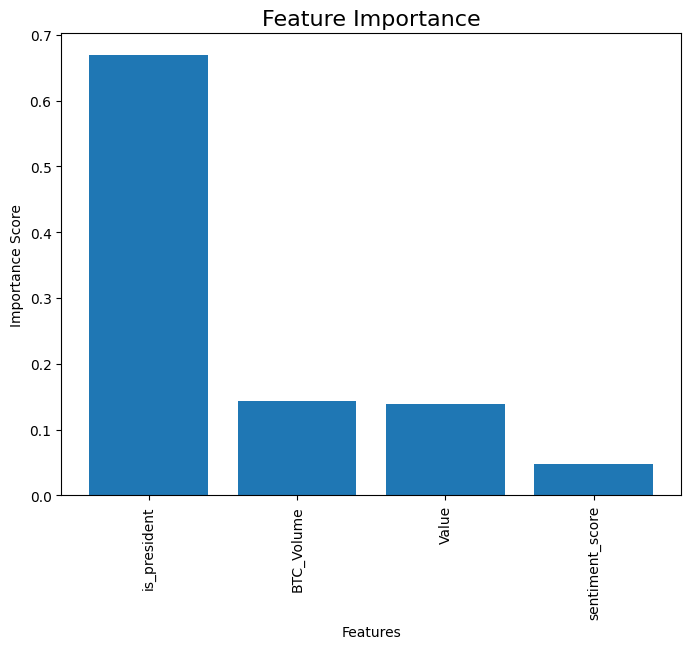

In [19]:
import matplotlib.pyplot as plt
import numpy as np

# Extract feature importance values from the trained model
importances = np.array(rf_model.featureImportances.toArray())

# Get feature names (make sure to match feature order from VectorAssembler)
feature_names = X_train.schema["features"].metadata["ml_attr"]["attrs"]["numeric"]

# Extract names and importance values
feature_names = [f["name"] for f in feature_names]
sorted_indices = np.argsort(importances)[::-1]  # Sort in descending order

# Plot feature importance
plt.figure(figsize=(8,6))
plt.bar(np.array(feature_names)[sorted_indices], importances[sorted_indices])
plt.xticks(rotation=90)
plt.title("Feature Importance", fontsize=16)
plt.xlabel("Features")
plt.ylabel("Importance Score")
plt.show()


In [20]:
rf_model.write().overwrite().save(f"{hdfs_lakehouse_base_path}/gold/trump_btc/rf_model")
